# Portfolio Assignment 4

**Study Group 8, Emma Rose Hahn (EH), Viara Krasteva (VK), Kristian Nøhr Villebro (KV), Luke Ring (LR)**

### Student numbers

- Emma Rose Hahn: 202004249
- Kristian Nøhr Villebro: 202005289
- Luke Ring: 202009983
- Viara Krasteva: 202005673


In [1]:
# methods3 conda environment
# imports
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# common functions
def equalize_targets(data, y):
    np.random.seed(7)
    targets = np.unique(y)
    counts = list()
    indices = list()
    for target in targets:
        counts.append(np.sum(y == target))
        indices.append(np.where(y == target)[0])
    min_count = np.min(counts)
    first_choice = np.random.choice(indices[0], size=min_count, replace=False)
    second_choice = np.random.choice(indices[1], size=min_count, replace=False)
    third_choice = np.random.choice(indices[2], size=min_count, replace=False)
    fourth_choice = np.random.choice(indices[3], size=min_count, replace=False)
    
    new_indices = np.concatenate((first_choice, second_choice,
                                 third_choice, fourth_choice))
    new_y = y[new_indices]
    new_data = data[new_indices, :, :]
    
    return new_data, new_y

## Exercise 1 - Use principal component analysis to improve the classification of subjective experience

### 1.1 - Create a covariance matrix, find the eigenvectors and the eigenvalues (EH)

In [3]:

data = np.load('megmag_data.npy')
pas_data = np.load('pas_vector.npy')

#### 1.1.ii) Equalize the number of targets in y and data using equalize_targets

In [4]:
data, y = equalize_targets(data, pas_data)

#### 1.1.iii) times and 1.1.iii) reduce to two dimensions only using 248ms

In [5]:

times=np.arange(-200, 804, 4) 
data_reduced = data[:, :, np.where(times == 248)[0][0]]


#### 1.1.iv) Scale the data using StandardScaler

In [6]:
sc = StandardScaler()
data_scaled = sc.fit_transform(data_reduced, y)


#### 1.1.v) Calculate the sample covariance matrix using np.cov

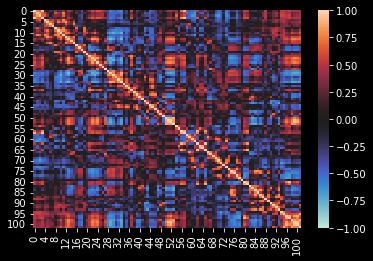

In [7]:
cov_matrix = np.cov(data_scaled, rowvar=False)
# plot using seaborn heatmap
sns.heatmap(cov_matrix, cmap='icefire', vmin=-1, vmax=1)
plt.show()

#### 1.1.vi) What does the off-diagonal activation imply about the independence of the signals measured by the 102 sensors? (KV)

We see that the off-diagonal activation implies that the signals measured by the sensors are not independent. This makes sense as activity in the brain can involve multiple regions, and we would expect to see some correlation and covariance between sensors.

#### 1.1.vii Run np.linalg.matrix_rank on the covariance matrix - what integer value do you get? (we'll use this later)

In [8]:
rank = np.linalg.matrix_rank(cov_matrix)
print("Matrix rank: {}".format(rank))

Matrix rank: 97


#### 1.1.viii) Find the eigenvalues and eigenvectors of the covariance matrix using np.linalg.eig

In [9]:
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
# Use np.real to retrieve only the real parts of the eigenvalues and eigenvectors
eigenvalues = np.abs(np.real(eigenvalues))
eigenvectors = np.real(eigenvectors)


### 1.2 - Create the weighting matrix W and the projected data, Z

#### 1.2.i to 1.2.iii) sort the eigenvectors and eigenvalues according to the absolute values of the eigenvalues

In [10]:
# get the sorted indices of absolute values in reverse order
sorted_indices = np.argsort(eigenvalues)[::-1]
# sorted eigenvalues
eigenvalues = eigenvalues[sorted_indices]
# sorted eigenvectors
eigenvectors = eigenvectors[:, sorted_indices]


#### 1.2.iv) Plot the log of the eigenvalues

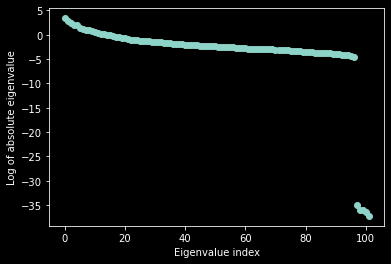

In [11]:
plt.plot(np.log(eigenvalues), 'o')
plt.xlabel('Eigenvalue index')
plt.ylabel('Log of absolute eigenvalue')
plt.show()


#### 1.2.iv) are there some values that stand out from the rest? (LR)

The last 5 of the sorted log eigenvalues are much smaller than the previous 97. This matches the result of our matrix rank test which gives values above a threshold. 

#### 1.2.v - 1.2.vi) eigenvectors are the weighting matrix, create projected data Z = W.X

In [12]:
Z = data_scaled @ eigenvectors
X = Z @ eigenvectors.T

# check if calculations are correct
closeness_check = np.isclose(data_scaled, X)
number_of_false_values = np.sum(closeness_check == False)
print("Number values that are not close: {}".format(number_of_false_values))

Number values that are not close: 0


(396, 102)


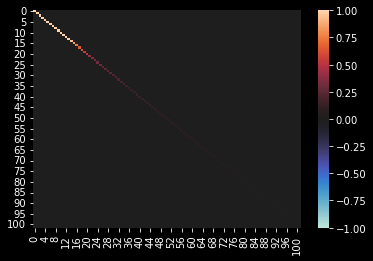

In [13]:
# 1.2.vii) Create a new covariance matrix of the principal components (n=102)
cov_matrix_pca = np.cov(Z, rowvar=False)
print(Z.shape)
# plot using seaborn heatmap
sns.heatmap(cov_matrix_pca, cmap='icefire', vmin=-1, vmax=1)
plt.show()

#### 1.2.vii What has happened to the off-diagonals and why? (LR)

The weighting matrix is the orthogonal projection of the data onto the eigenvectors, this results in values that are not correlated with each other, giving a 0 value for the covariance matrix.

## Exercise 2 - Use logistic regression with cross-validation to find the optimal number of principal components (VK)

#### 2.1.i) run standard logistic regression (no regularization) based on Zdxk and y

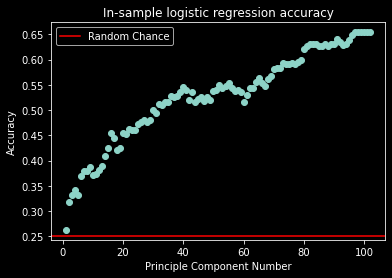

In [14]:
lr = LogisticRegression(fit_intercept=False, solver='newton-cg')
# fit 102 models based on: k=[1,2,...,101,102] and d=102. For each fit get the classification accuracy, (.score), when applied to Z_d×k and y
scores = list()
d = Z.shape[1]
for k in range(1, d+1):
    Z_kxd = Z[:, :k]
    lr.fit(Z_kxd, y)
    scores.append(lr.score(Z_kxd, y))

plt.scatter(np.arange(1, d+1), scores)
plt.axhline(0.25, color='red', label='Random Chance')
plt.xlabel('Principle Component Number')
plt.ylabel('Accuracy')
plt.title('In-sample logistic regression accuracy')
plt.legend()
plt.show()

#### 2.1.ii)  what is the general trend and why is this so? (EH)

Based on the above plot we could say the general trend is that addming more principle components results in a higher classification accuracy. This is because more variance is accounted for, but it also could mean that the model is overfitting.

#### 2.1.iii) In terms of classification accuracy, what is the effect of adding the five last components? Why do you think this is so? (KV)

The last 5 components have a negligible effect, this is because they are the principle components that have the least variance, adding them to our models doesn't provide much additional information.

### 2.2) cross validate using cross_val_score and StratifiedKFold (LR)

(102,)


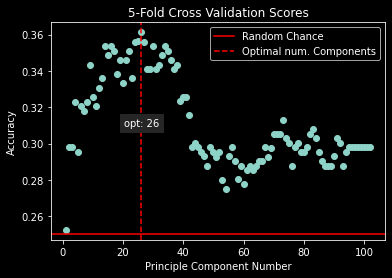

In [15]:

cv = StratifiedKFold()
scores = []
for k in range(1, d+1):
  Z_k = Z[:, :k]
  scores.append(cross_val_score(lr, Z_k, y, cv=cv))

scores = np.asarray(scores)
# get mean score for each k
mean_scores = np.mean(scores, axis=1)
# get index of max
max_index = np.argmax(mean_scores)
grand_mean = np.mean(mean_scores)

print(mean_scores.shape)
plt.scatter(np.arange(1, d+1), mean_scores)
plt.axhline(0.25, color='red', label='Random Chance')
plt.axvline(max_index+1, color='red', label='Optimal num. Components', linestyle='--')
plt.text(max_index+1, grand_mean, 'opt: {}'.format(max_index+1), horizontalalignment='center', verticalalignment='center', backgroundcolor='#262626', color='white')
plt.xlabel('Principle Component Number')
plt.ylabel('Accuracy')
plt.title('5-Fold Cross Validation Scores')
plt.legend()
plt.show()

#### 2.2.ii) how is this plot different from the one in Exercise 2.1.ii? (VK)

This shows a different trend, rather than each additional component increasing the model accuracy, we see a peak at 26 components and after that a decline in accuracy which then levels out at around 70 components. Based on the first model we might assume that adding all the components would result in a higher accuracy, where as using cross-validation we see that the results of the previous model were likely due to overfitting.

#### 2.2.iii) What is the number of principal components, $k_{max\_accuracy}$, that results in the greatest classification accuracy when cross-validated?

The peak model performance is 26 components, at around 36% accuracy.

In [16]:
print("Maximum classification accuracy: {:.2%}, classifaction accuracy with full dataset: {:.2%}, improvement: {:.2%}".format(mean_scores[max_index], mean_scores[-1], (mean_scores[max_index]-mean_scores[-1])))

Maximum classification accuracy: 36.13%, classifaction accuracy with full dataset: 29.79%, improvement: 6.33%


#### 2.2.iv) How many percentage points is the classification accuracy increased with relative to the to the full-dimensional, d, dataset? (EH)

using all of the components, the 5-fold cross-validation accuracy is increased by about 6.3%.

#### 2.2.v) How do the analyses in Exercises 2.1 and 2.2 differ from one another? Make sure to comment on the differences in optimization criteria. (KV)

Both use a logistic regression model, the key difference here is that the first analysis is adding components and fitting the model to the entire dataset. 2.2 uses stratified 5-fold cross-validation which tries to ensure balanced classes across the folds, as well as training and testing on different subsets of the data. This is a more robust method of testing the model, as it is less prone to overfitting and while the classification accuracy may seem lower, the accuracy in 2.1 is likely overinflated.

#### 2.3.i) For each of the 251 time samples, use the same estimator and cross-validation as in Exercises 2.1.i and 2.2.i. (LR)


In [17]:
scores_pca = []
scores_all = []
time_steps = len(times)
print("Running analyses for {} time samples from {}ms to {}ms:".format(time_steps, times[0], times[-1]), flush=True)
for t in range(time_steps):
  print("{}ms".format(times[t]), end="", flush=True)
  # get data for current timestamp
  data_t = data[:, :, t]
  data_t_scaled = sc.transform(data_t)
  # use pca to reduce to k_max
  pca_kmax = PCA(n_components=max_index+1)
  pcs = pca_kmax.fit_transform(data_t_scaled)
  # calculate cross validation scores for reduced data
  scores_pca.append(cross_val_score(lr, pcs, y, cv=cv))
  print(".", end="", flush=True)
  # calculate cross validation scores for all data
  scores_all.append(cross_val_score(lr, data_t_scaled, y, cv=cv))
  print(".", end="", flush=True)
print("done\nPreparing plot...", flush=True)
  

Running analyses for 251 time samples from -200ms to 800ms:
-200ms..-196ms..-192ms..-188ms..-184ms..-180ms..-176ms..-172ms..-168ms..-164ms..-160ms..-156ms..-152ms..-148ms..-144ms..-140ms..-136ms..-132ms..-128ms..-124ms..-120ms..-116ms..-112ms..-108ms..-104ms..-100ms..-96ms..-92ms..-88ms..-84ms..-80ms..-76ms..-72ms..-68ms..-64ms..-60ms..-56ms..-52ms..-48ms..-44ms..-40ms..-36ms..-32ms..-28ms..-24ms..-20ms..-16ms..-12ms..-8ms..-4ms..0ms..4ms..8ms..12ms..16ms..20ms..24ms..28ms..32ms..36ms..40ms..44ms..48ms..52ms..56ms..60ms..64ms..68ms..72ms..76ms..80ms..84ms..88ms..92ms..96ms..100ms..104ms..108ms..112ms..116ms..120ms..124ms..128ms..132ms..136ms..140ms..144ms..148ms..152ms..156ms..160ms..164ms..168ms..172ms..176ms..180ms..184ms..188ms..192ms..196ms..200ms..204ms..208ms..212ms..216ms..220ms..224ms..228ms..232ms..236ms..240ms..244ms..248ms..252ms..256ms..260ms..264ms..268ms..272ms..276ms..280ms..284ms..288ms..292ms..296ms..300ms..304ms..308ms..312ms..316ms..320ms..324ms..328ms..332ms..336ms.

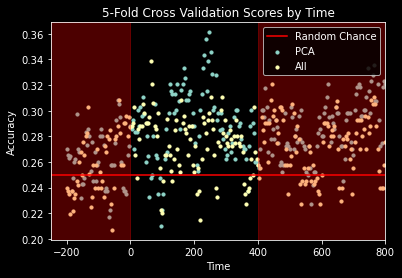

In [18]:
# plot scores by time (VK)
mean_pca_scores = np.mean(scores_pca, axis=1)
mean_all_scores = np.mean(scores_all, axis=1)

fig, ax = plt.subplots()
ax.axhline(0.25, color='red', label='Random Chance')
ax.scatter(times, mean_pca_scores, label='PCA', s=10)
ax.scatter(times, mean_all_scores, label='All', s=10)
ax.axvspan(-250, 0, color="red", alpha=0.3)
ax.axvspan(400, 800, color="red", alpha=0.3)
plt.xlim([-250, 800])
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.title('5-Fold Cross Validation Scores by Time')
plt.legend(loc='upper right')
plt.show()

#### 2.3.iii) Describe the differences between the two analyses - focus on the time interval between 0 ms and 400 ms - describe in your own words why the logistic regression performs better on the PCA-reduced dataset around the peak magnetic activity (EH)

The PCA reduced dataset performance tends to be higher than the full dataset, especially around peak activity. The full dataset contains the signal from all the sensors, but some of these may be less relevant to the response being investigated thereby introducing noise into the model. As hypothesized in 2.2.v, the overall accuracy of the full dataset was inflated due to overfitting which reduced its ability to be generalized to other time intervals. Unsurprisingly, as the PCA model underwent more robust validation, the accuracy at the previously modelled timestamp (248ms) remained the same (~36%), and seems to be able to generalize to time intervals around the peak activity, where the signal is likely similar.
